In [1]:
# Data from Chest X-Ray (Pneumonia) Dataset on Kaggle.com

In [2]:
# For Google Colab
# !pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
# import os
# credentials = {"username":"allenkong","key":"ff55d7dfb506afea9e36c7aadfaa00e5"}
# os.environ['KAGGLE_USERNAME']=credentials["username"]
# os.environ['KAGGLE_KEY']=credentials["key"]

In [3]:
# For Google Colab
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip chest-xray-pneumonia.zip

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.8 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jun 27 20:30:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
from pathlib import Path
import os
import glob
import cv2
import torch
import numpy as np
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

In [7]:
# Kaggle Notebook
DATA_DIR = Path("../input/chest-xray-pneumonia/chest_xray")

TRAIN_P_DIR = DATA_DIR/'train/PNEUMONIA'
TRAIN_N_DIR = DATA_DIR/'train/NORMAL'

TEST_P_DIR = DATA_DIR/'test/PNEUMONIA'
TEST_N_DIR = DATA_DIR/'test/NORMAL'

VAL_P_DIR = DATA_DIR/'val/NORMAL'
VAL_N_DIR = DATA_DIR/'val/PNEUMONIA'

In [8]:
# Colab Notebook
# DATA_DIR = Path('/content/chest_xray')

# TRAIN_P_DIR = DATA_DIR/'train/PNEUMONIA'
# TRAIN_N_DIR = DATA_DIR/'train/NORMAL'

# TEST_P_DIR = DATA_DIR/'test/PNEUMONIA'
# TEST_N_DIR = DATA_DIR/'test/NORMAL'

# VAL_P_DIR = DATA_DIR/'val/NORMAL'
# VAL_N_DIR = DATA_DIR/'val/PNEUMONIA'

In [9]:
!ls "{TRAIN_P_DIR}" | head

person1000_bacteria_2931.jpeg
person1000_virus_1681.jpeg
person1001_bacteria_2932.jpeg
person1002_bacteria_2933.jpeg
person1003_bacteria_2934.jpeg
person1003_virus_1685.jpeg
person1004_bacteria_2935.jpeg
person1004_virus_1686.jpeg
person1005_bacteria_2936.jpeg
person1005_virus_1688.jpeg
ls: write error: Broken pipe


In [10]:
!ls "{TRAIN_N_DIR}" | head

IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg
ls: write error: Broken pipe


In [11]:
# Get the list of all the images
TRAIN_P = TRAIN_P_DIR.glob('*.jpeg')
TRAIN_N = TRAIN_N_DIR.glob('*.jpeg')

TEST_P = TEST_P_DIR.glob('*.jpeg')
TEST_N = TEST_N_DIR.glob('*.jpeg')

VAL_P = VAL_P_DIR.glob('*.jpeg')
VAL_N = VAL_N_DIR.glob('*.jpeg')

TRAIN_DATA = []
TEST_DATA = []
VAL_DATA = []

for i in TRAIN_P:
    TRAIN_DATA.append((i,1))
for i in TRAIN_N:
    TRAIN_DATA.append((i,0))
    
for i in TEST_P:
    TEST_DATA.append((i,1))
for i in TEST_N:
    TEST_DATA.append((i,0))

for i in VAL_P:
    VAL_DATA.append((i,1))
for i in VAL_N:
    VAL_DATA.append((i,0))

# Transform array to Pandas Dataframe
TRAIN_DATA = pd.DataFrame(TRAIN_DATA, columns=['image', 'label'],index=None)
TRAIN_DATA = TRAIN_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

TEST_DATA = pd.DataFrame(TEST_DATA, columns=['image', 'label'],index=None)
TEST_DATA = TEST_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

VAL_DATA = pd.DataFrame(VAL_DATA, columns=['image', 'label'],index=None)
VAL_DATA = VAL_DATA.sample(frac=1.,random_state=15).reset_index(drop=True)

In [12]:
len(TRAIN_DATA), len(VAL_DATA), len(TEST_DATA)

(5216, 16, 624)

1    3875
0    1341
Name: label, dtype: int64


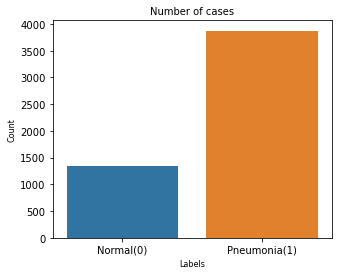

1    8
0    8
Name: label, dtype: int64


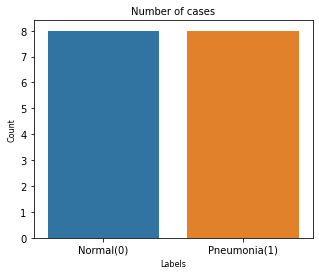

1    390
0    234
Name: label, dtype: int64


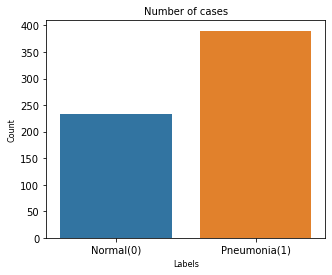

In [13]:
for x in [TRAIN_DATA, VAL_DATA, TEST_DATA]:
  # Get the counts for each class
  cases_count = x['label'].value_counts()
  print(cases_count)

  # Plot the results 
  plt.figure(figsize=(5,4))
  sns.barplot(x=cases_count.index, y= cases_count.values)
  plt.title('Number of cases', fontsize=10)
  plt.xlabel('Labels', fontsize=8)
  plt.ylabel('Count', fontsize=8)
  plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
  plt.show()

In [14]:
labels = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [15]:
full_data = pd.concat([TRAIN_DATA,VAL_DATA], ignore_index=True)
full_data = full_data.sample(frac=1.,random_state=17).reset_index(drop=True)

1    3883
0    1349
Name: label, dtype: int64


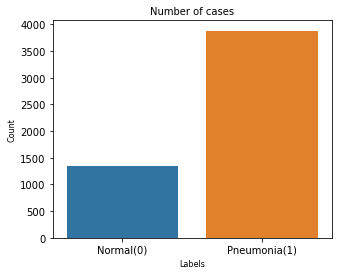

In [16]:
cases_count = full_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=10)
plt.xlabel('Labels', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [17]:
class PneumoniaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image'], row['label']
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        return img, img_label

In [18]:
np.random.seed(42)
msk = np.random.rand(len(full_data)) < 0.8

train_df = full_data[msk].reset_index()
val_df = full_data[~msk].reset_index()

In [19]:
train_transform = T.Compose([T.Resize((256,256)),
                             T.RandomAffine(30),
                             T.ColorJitter(),
                             T.ToTensor()])
val_transform = T.Compose([T.Resize((256,256)),
                           T.ToTensor()])

In [20]:
train_dataset = PneumoniaDataset(train_df, transform=train_transform)
val_dataset = PneumoniaDataset(val_df, transform=val_transform)
len(train_dataset), len(val_dataset)

(4191, 1041)

In [21]:
batch_size = 16

In [22]:
# PyTorch data loaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

In [23]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=4).permute(1, 2, 0))
        break

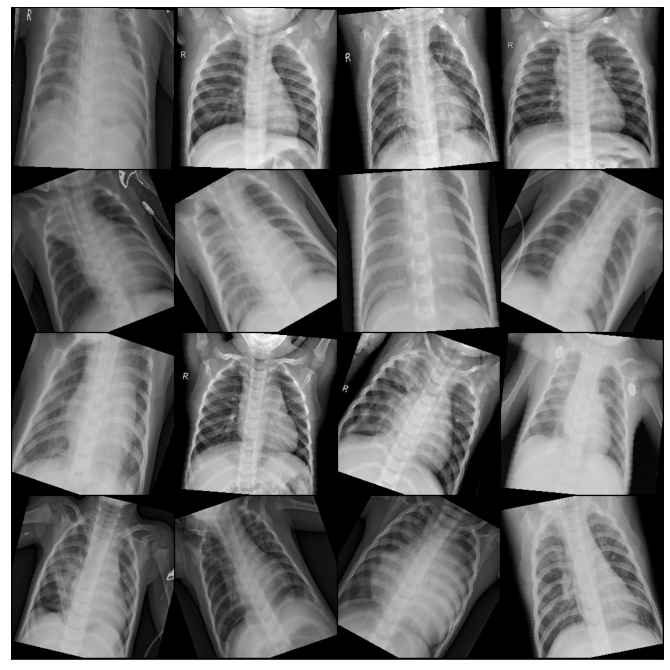

In [24]:
show_batch(train_dl)

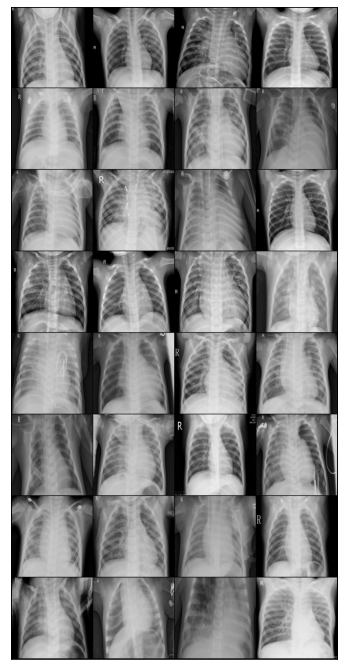

In [25]:
show_batch(val_dl)

In [26]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
device = get_default_device()
device

device(type='cuda')

In [28]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [30]:
class PneumoniaClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [31]:
class PneumoniaResnet(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Dropout(0.5)
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
model = to_device(PneumoniaResnet(), device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [34]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6969262957572937, 'val_score': 0.5226715803146362}]

In [35]:
model.freeze()

In [36]:
epochs = 5
max_lr = 30e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [37]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.0023, train_loss: 0.2090, val_loss: 1.4753, val_score: 0.6424
Epoch [1], last_lr: 0.0029, train_loss: 0.2512, val_loss: 0.2300, val_score: 0.9139
Epoch [2], last_lr: 0.0018, train_loss: 0.1633, val_loss: 0.5457, val_score: 0.7976
Epoch [3], last_lr: 0.0006, train_loss: 0.1209, val_loss: 0.0822, val_score: 0.9728
Epoch [4], last_lr: 0.0000, train_loss: 0.0952, val_loss: 0.0568, val_score: 0.9812
CPU times: user 1min 2s, sys: 7.29 s, total: 1min 9s
Wall time: 9min 37s


In [38]:
model.unfreeze()

In [39]:
%%time
history += fit_one_cycle(epochs, 1e-5, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], last_lr: 0.0000, train_loss: 0.0843, val_loss: 0.0556, val_score: 0.9820
Epoch [1], last_lr: 0.0000, train_loss: 0.0735, val_loss: 0.0539, val_score: 0.9831
Epoch [2], last_lr: 0.0000, train_loss: 0.0760, val_loss: 0.0539, val_score: 0.9840
Epoch [3], last_lr: 0.0000, train_loss: 0.0756, val_loss: 0.0543, val_score: 0.9850
Epoch [4], last_lr: 0.0000, train_loss: 0.0735, val_loss: 0.0524, val_score: 0.9848
CPU times: user 1min 2s, sys: 7.53 s, total: 1min 10s
Wall time: 9min 38s


In [40]:
def plot_accuracies(history):
    accuracies = [x['val_score'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

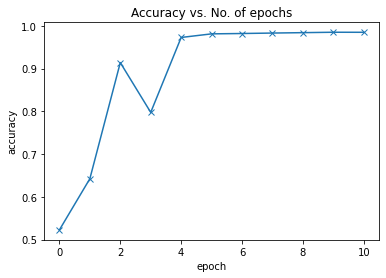

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

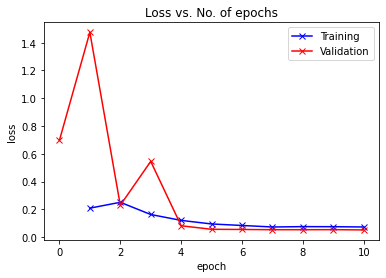

In [43]:
plot_losses(history)

In [44]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

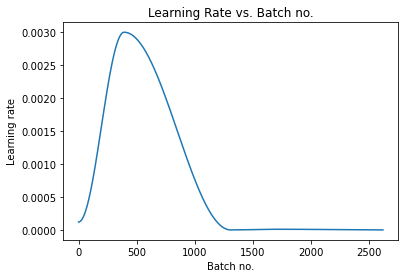

In [45]:
plot_lrs(history)

In [46]:
test_dataset = PneumoniaDataset(TEST_DATA, transform=val_transform)
test_dl = DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True)

In [47]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Normal , Predicted: Pneumonia


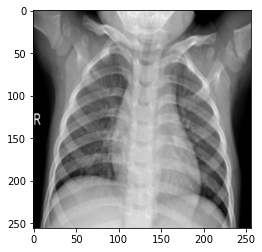

In [48]:
img, label = test_dataset[2]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

Label: Normal , Predicted: Normal


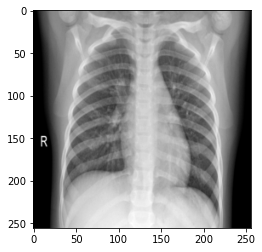

In [49]:
img, label = test_dataset[7]
plt.imshow(img[0], cmap='gray')
print('Label:', labels[label], ', Predicted:', labels[predict_image(img, model)])

In [50]:
test_dl = DeviceDataLoader(test_dl, device)

In [51]:
evaluate(model, test_dl)

{'val_loss': 0.5232722163200378, 'val_score': 0.8365384340286255}

In [52]:
# CNN Model 13 layers with Batch Normalization and Dropout
class CNNModel13(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(512*256, 1024),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2, bias=True))
        
    def forward(self, xb):
        return self.network(xb)

In [53]:
model2 = to_device(CNNModel13(), device)

In [54]:
history2 = [evaluate(model2, val_dl)]
history2

[{'val_loss': 0.6866969466209412, 'val_score': 0.7383578419685364}]

In [55]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.0023, train_loss: 0.1428, val_loss: 0.3814, val_score: 0.8419
Epoch [1], last_lr: 0.0029, train_loss: 0.1997, val_loss: 1.6400, val_score: 0.7392
Epoch [2], last_lr: 0.0018, train_loss: 0.1595, val_loss: 0.4210, val_score: 0.8299
Epoch [3], last_lr: 0.0006, train_loss: 0.1312, val_loss: 0.1052, val_score: 0.9631
Epoch [4], last_lr: 0.0000, train_loss: 0.0971, val_loss: 0.0681, val_score: 0.9774
CPU times: user 1min 2s, sys: 7.27 s, total: 1min 9s
Wall time: 9min 41s


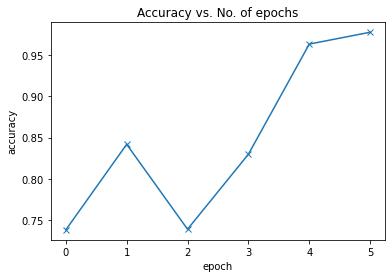

In [56]:
plot_accuracies(history2)

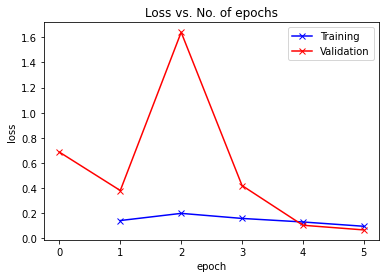

In [57]:
plot_losses(history2)

In [58]:
evaluate(model2, test_dl)

{'val_loss': 0.6898097395896912, 'val_score': 0.625}

In [65]:
# CNN Model 8 layers
class CNNModel8(PneumoniaClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(262144, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [66]:
model3 = to_device(CNNModel9(), device)

In [67]:
history3 = [evaluate(model3, val_dl)]
history3

[{'val_loss': 0.7122641205787659, 'val_score': 0.25829991698265076}]

In [68]:
%%time
history3 += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.0023, train_loss: 0.1127, val_loss: 0.2108, val_score: 0.9225
Epoch [1], last_lr: 0.0029, train_loss: 0.1703, val_loss: 0.1015, val_score: 0.9650
Epoch [2], last_lr: 0.0018, train_loss: 0.1606, val_loss: 0.2102, val_score: 0.9368
Epoch [3], last_lr: 0.0006, train_loss: 0.1057, val_loss: 0.0652, val_score: 0.9811
Epoch [4], last_lr: 0.0000, train_loss: 0.0864, val_loss: 0.0611, val_score: 0.9848
CPU times: user 1min 2s, sys: 7.14 s, total: 1min 9s
Wall time: 9min 43s


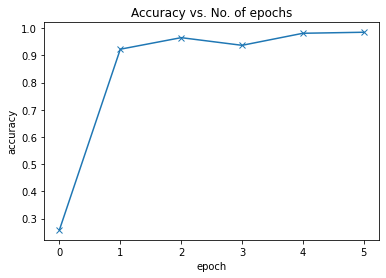

In [69]:
plot_accuracies(history3)

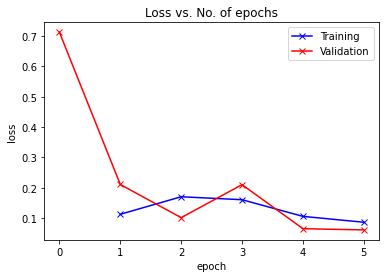

In [70]:
plot_losses(history3)

In [71]:
evaluate(model3, test_dl)

{'val_loss': 0.7033966183662415, 'val_score': 0.375}

In [72]:
!pip install jovian --upgrade -q

In [73]:
import jovian

<IPython.core.display.Javascript object>

In [ ]:
jovian.commit(project='pneumonia-detection-resnet')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/allenkong221/pneumonia-detection-resnet


<IPython.core.display.Javascript object>